Грузим датасет:

In [1]:
cd ..

/home/bfilippov/kaggle/whiteboard


In [2]:
import keras
import pandas as pd
import ast

train = pd.read_csv('source/train.csv')
test = pd.read_csv('source/test.csv')
train['labels'] = train['labels'].map(ast.literal_eval)
test['labels'] = test['labels'].map(ast.literal_eval)

Using TensorFlow backend.


Объявляем модель:

In [3]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf

from keras.layers import Input
from keras import backend as K

from models.model_zoo import lenet_like_convnet, whiteboard_detector, whiteboard_loss
from models.image_generator import whiteboard_images

sess = tf.Session()
K.set_session(sess)

input_height = 128
input_width = 128

input_image = Input(shape=(input_height, input_width, 3))
lenet = lenet_like_convnet(input_image)

simple_detector = whiteboard_detector(input_image, lenet)

simple_detector.compile(optimizer='adam', loss=whiteboard_loss)


Учим модель:

In [4]:
img_dir = 'source/'
img_size = (input_height, input_width)

imgs = whiteboard_images(train, img_dir, img_size)

simple_detector.fit_generator(imgs, samples_per_epoch=2000, nb_epoch=10)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Epoch 1/10
2016/2000 [==============================] - 277s - loss: 1.9874   

/home/bfilippov/anaconda3/lib/python3.5/site-packages/keras/engine/training.py:1480: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '



Epoch 2/10
2016/2000 [==============================] - 323s - loss: 1.3413   
Epoch 3/10
2016/2000 [==============================] - 356s - loss: 1.1909   
Epoch 4/10
2016/2000 [==============================] - 360s - loss: 1.1232   
Epoch 5/10
2016/2000 [==============================] - 361s - loss: 1.0969   
Epoch 6/10
2016/2000 [==============================] - 382s - loss: 1.0291   
Epoch 7/10
2016/2000 [==============================] - 363s - loss: 1.0370   
Epoch 8/10
2016/2000 [==============================] - 352s - loss: 1.0164   
Epoch 9/10
2016/2000 [==============================] - 351s - loss: 0.9933   
Epoch 10/10
2016/2000 [==============================] - 346s - loss: 0.9427   


In [7]:
valid_imgs = whiteboard_images(test, img_dir, img_size)
valid_batch_input, valid_batch_labels = next(valid_imgs)
predictions = simple_detector.predict_on_batch(valid_batch_input)

Выглядит так что сетка пытается детектировать доску не смотря на её углы:

is present? 1.0


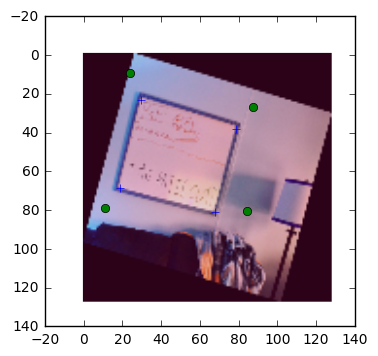

In [12]:
%matplotlib inline
from matplotlib import pyplot as plt

img_ix = 11

plt.imshow(valid_batch_input[img_ix])
plt.plot(valid_batch_labels[img_ix][2:6], valid_batch_labels[img_ix][6:10], '+')
plt.plot(predictions[img_ix][2:6], predictions[img_ix][6:10], 'o')

print("is present?", predictions[img_ix][1])

In [7]:
simple_detector.save('')